In [1]:
import torch, cv2, copy, os
import numpy as np
import torch.nn as nn
from typing import Iterable
from torchvision.models.resnet import BasicBlock, Bottleneck
from model.architecture import GWDetectionNET
from data_preparation.dataset import FrameDataset
from data_preparation.generate_bbox import draw_bbox as draw_bbox_on_mask
from matplotlib import pyplot as plt

# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# torch.autograd.set_detect_anomaly(True)

In [2]:
test_data_path = "data/Test_data"
img_size = (256,  256)

test_dataset = FrameDataset(test_data_path, grayscale=True, size=img_size)

In [3]:
# model params
in_channels = 1
n_classes = 0
dropout = 0.2
block = BasicBlock
block_layers = [2, 2, 2, 2]
pretrained_backbone = None #"resnet18"
last_fmap_ch = 512
anchor_path = "anchors/anchors.json"
model_folder = "saved_model"
model_name = f"gw_detection_model.pth.tar"
device = "cuda" if torch.cuda.is_available() else "cpu"

model = GWDetectionNET(
    in_channels, 
    img_size=img_size,
    anchors_path=anchor_path, 
    n_classes=n_classes, 
    block=block, 
    block_layers=block_layers,
    pretrained_resnet_backbone=pretrained_backbone, 
    last_fmap_ch=last_fmap_ch,
    use_locnet=True,
    use_segnet=True
)

In [4]:
def prepare_img_and_bbox(
        img: torch.Tensor, 
        bbox: torch.Tensor, 
        scaled_bbox: bool=True,
        xy_centered: bool=True):
    img = (img * 255).type(torch.uint8).squeeze().numpy()

    if bbox.shape[0] == 4:
        x, y, w, h = bbox
    else:
        _, x, y, w, h = bbox

    if scaled_bbox:
        x *= img.shape[1]
        y *= img.shape[0]
        w *= img.shape[1]
        h *= img.shape[0]

    if xy_centered:
        x = x-(w/2)
        y = y-(h/2)
    bbox = np.array([x, y, w, h]).astype(int)
    return img, bbox

def draw_bbox_on_img(img :np.ndarray, bbox: Iterable[int], single_channel: bool=True):
    if bbox.shape[0] == 4:
        x, y, w, h = bbox
    else:
        _, x, y, w, h = bbox
    ch = (0, 200, 90) if not single_channel else (255)
    return cv2.rectangle(img, (x, y), (x+w, y+h), ch, 1)


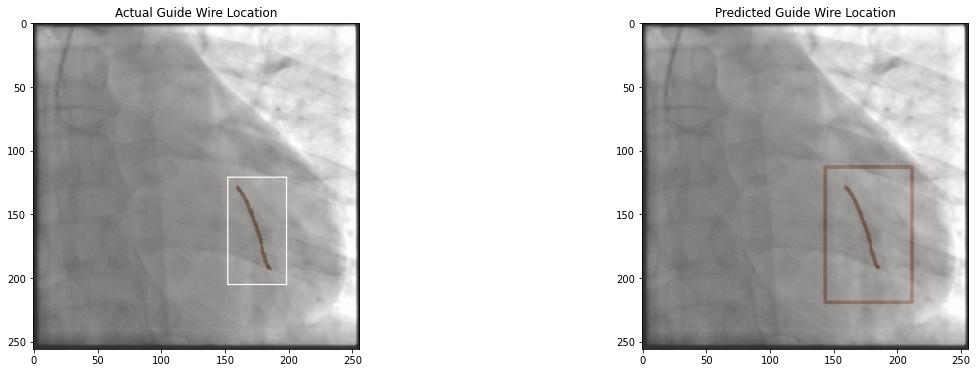

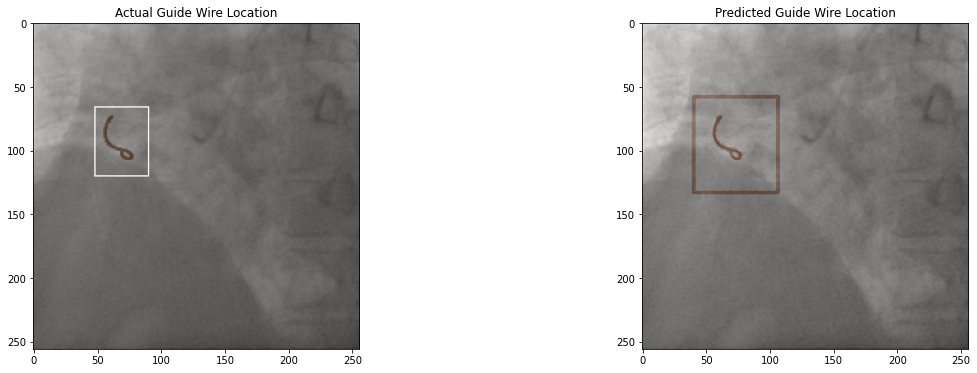

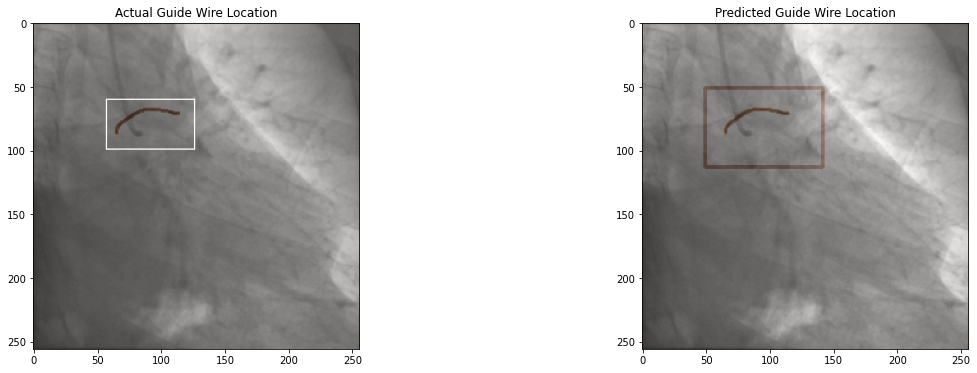

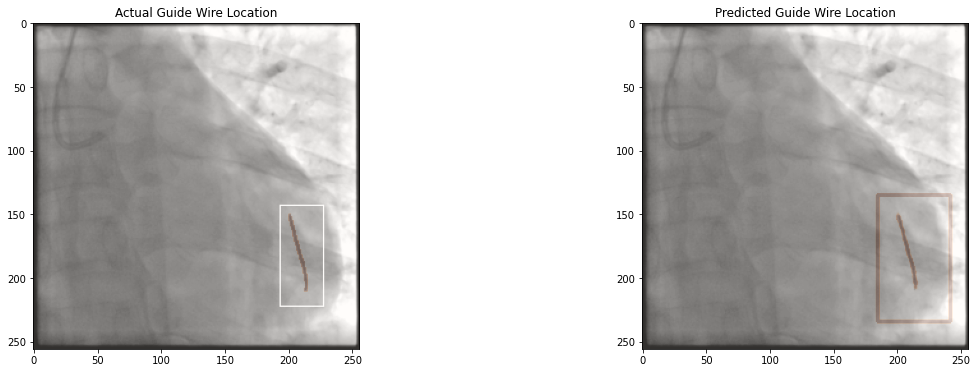

In [12]:
model.load_state_dict(
    torch.load(os.path.join(model_folder, model_name), map_location=device)["network_params"]
)  # load best saved model

for i in range(4):
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))

    # Actual Labels
    sample_image, sample_bbox, sample_mask = test_dataset[np.random.randint(0, len(test_dataset))]
    processed_sample_img, processed_sample_bbox = prepare_img_and_bbox(sample_image, sample_bbox)
    bbox_sample_img = draw_bbox_on_img(copy.deepcopy(processed_sample_img), processed_sample_bbox)

    axs[0].imshow(bbox_sample_img, cmap="gray")
    axs[0].imshow(sample_mask.squeeze(), alpha=0.2, cmap="Oranges")
    axs[0].set_title("Actual Guide Wire Location")

    with torch.no_grad():
        _, pred_mask = model(sample_image.to(device).unsqueeze(dim=0))
    pred_mask = pred_mask.squeeze().cpu() * 255
    pred_mask = pred_mask.type(torch.uint8).numpy()
    mask_with_box, bbox = draw_bbox_on_mask(pred_mask, save_bbox=False, scale_bbox=False, center_xy=False, line_thickness=2)

    axs[1].imshow(sample_image.cpu().squeeze(), cmap="gray")
    axs[1].imshow(mask_with_box, alpha=0.2, cmap="Oranges")
    axs[1].set_title(f"Predicted Guide Wire Location")
    plt.show()